In [2]:
%pylab inline
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns
from tqdm import trange

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings('ignore') 

import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [24]:
# To avoid overwriting figures 
import datetime
now = datetime.datetime.now()


In [8]:
#preprocess outputs

summary_dir = '/mnt/hd0/Pain_ML_data/summaries'
summary_filenames = ['deg_summaries.pkl','kpms_summaries.pkl', 
                     'palmreader_features_summaries.pkl', 'features_one_hot.pkl', 'ARBEL_summaries.pkl'
                    ]
summary_paths = [os.path.join(summary_dir,i) for i in summary_filenames]

keywords = ['deg','kpms','palmreader', 'hot', 'ARBEL'] #hot is a quick-fix 10.16.24
summaries = {}
for summary in summary_paths:
    for keyword in keywords:
        #there has to be a better way of doing this
        if keyword in summary:
            with open(summary, 'rb') as f:
                summaries[keyword] = pickle.load(f)


In [9]:
# preprocessing: features data has some data that the deg group needs


In [10]:
exp_group_mapping = {summaries['deg'][i][0]:i for i in range(len(summaries['deg']))}
exp_groups = [i for i in exp_group_mapping.keys()]
print(exp_group_mapping)

data, data_labels = {},{}
for technique, technique_data in summaries.items():
    print(f'processsing {technique}')
    items, labels = [],[]
    for exp_group, behavior_data in technique_data:
        mapping = exp_group_mapping[exp_group] #TEST
        for item in behavior_data:
            # Flattening arrays and adding labels to an identically shaped array
            items.append(item)
            labels.append(mapping)
    # adding data from technique to main dict
    data[technique] = np.array(items)
    data_labels[technique] = np.array(labels)
for k,v in data.items():
    print(k,':',len(v))

{'formalin': 0, 'capsaicin': 1, 'pbs': 2}
processsing deg
processsing kpms
processsing palmreader
processsing hot
processsing ARBEL
deg : 38
kpms : 38
palmreader : 38
hot : 38
ARBEL : 38


In [11]:
# Data from hot and deg need to be combined
print('deg:',data['deg'].shape, '| hot:',data['hot'].shape)
combined = np.concatenate((data['deg'], data['hot']), axis=1)
print('combined:',combined.shape)

data['deg'] = combined
del data['hot']
del data_labels['hot']

deg: (38, 4) | hot: (38, 2)
combined: (38, 6)


In [12]:
data['kpms'].shape

(38, 15)

In [13]:
# save data and the labels as one file
combined_data = (data, data_labels)
target_path = '/mnt/hd0/Pain_ML_data/summaries/combined_data.pkl'
with open(target_path, 'wb') as f:
    pickle.dump(combined_data, f)

## Load Data

In [14]:
filename = 'combined_data.pkl'
fig_path = '/mnt/hd0/Pain_ML_data/summaries/figs'

In [15]:
# with open(filename, 'rb') as f:
#     fingerprints, fingerprint_labels = pickle.load(f)

with open(target_path, 'rb') as f:
    fingerprints, fingerprint_labels = pickle.load(f)

## Classifier-Fitting Code

In [16]:
def train_linear_classifier(features, labels, C=100.0, n_fold=1, test_size=0.2, seed=0):

    splits = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)\
               .split(features, labels)
    train_ind, test_ind = next(splits)
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', multi_class='ovr', class_weight='balanced')
    model.fit(features[train_ind], labels[train_ind])
    pred_labels = model.predict(features[test_ind])
    scores = model.predict_proba(features[test_ind])
    true_labels = labels[test_ind]

    return true_labels, pred_labels, scores

## Choose a label level and other hyparparameters

In [17]:
feature_types = ['palmreader','ARBEL','kpms']
y = fingerprint_labels['kpms'] #turns out doesn't need y for each group. just one for all
unique_labels = exp_groups
print(unique_labels)
n_labels = len(unique_labels)
label_binarizer = LabelBinarizer().fit(np.arange(n_labels))

n_samples = 500 # for bootstrap measurements

['formalin', 'capsaicin', 'pbs']


In [18]:
# fingerprints['moseq'][0]
print(y)
print(np.unique(y,return_counts=True))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2]
(array([0, 1, 2]), array([20, 11,  7]))


## Train a Classifier and Calculate Performance Metrics

In [20]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    x = fingerprints[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for iseed in trange(n_samples):
        true_labels, pred_labels, scores = train_linear_classifier(x, y, seed=iseed)
        all_true_labels.append(label_binarizer.transform(true_labels))
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
  
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        np.array(all_true_labels).ravel(), np.array(all_scores).ravel()
    )
    f1s[feature_type] = np.mean(f1s[feature_type], axis=0) # average over seeds

Working on palmreader


100%|█████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 258.23it/s]


Working on ARBEL


100%|█████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 353.04it/s]


Working on kpms


100%|█████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 273.39it/s]


#### Plotting utilities and settings

In [22]:
# Plotting 
def make_label(feature_type):
    return f'{feature_type} F1: {np.mean(f1s[feature_type]):.2f} ± {np.std(f1s[feature_type])/np.sqrt(n_labels):.2f}'
    return f'{feature_type} F1: {np.mean(f1s[feature_type]):.2f} ± {np.std(f1s[feature_type])/np.sqrt(n_labels):.2f}'

feature_color = {
    'palmreader': '#B4AD33',
    'ARBEL': '#7C449A',
    'kpms': '#7C449A',
}

feature_mark = {
    'palmreader': '-',
    'ARBEL': '-',
    'kpms': '--',
}

#### Show Precision-Recall Curves and F1 scores

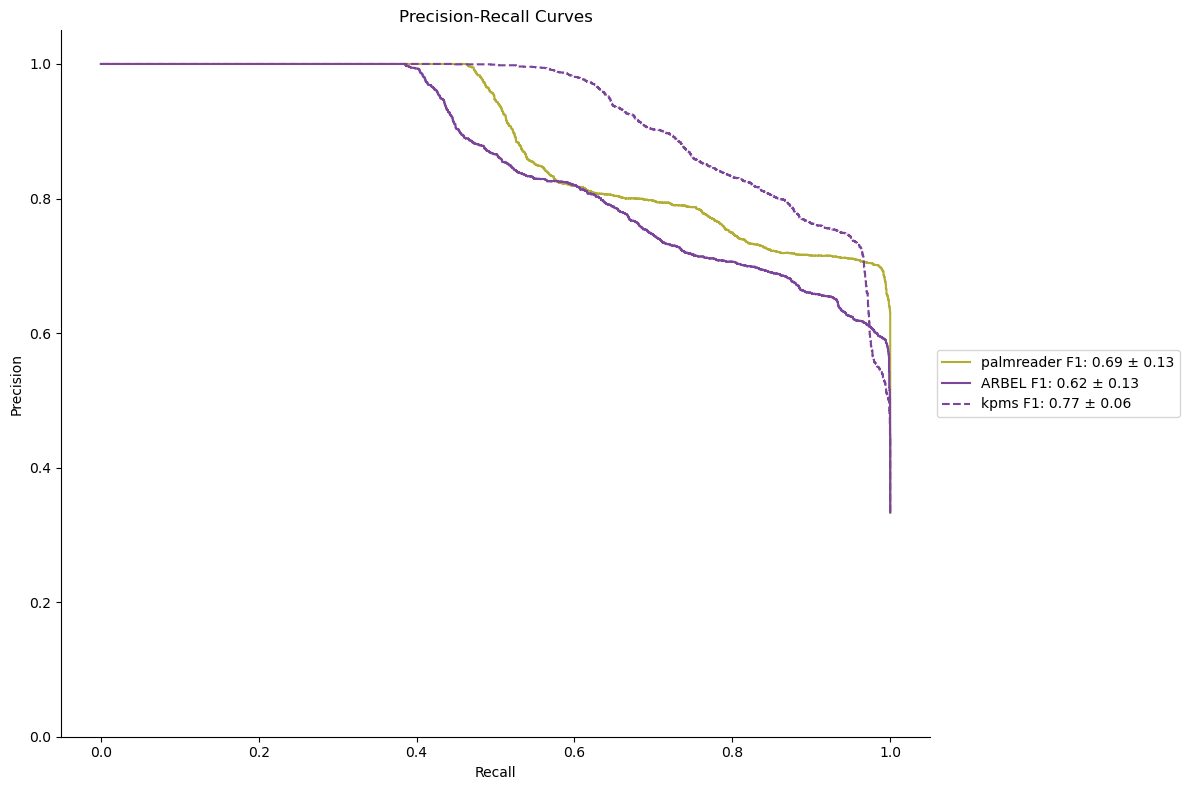

In [25]:
plt.figure(figsize=(12, 8))

for feature_type in feature_types:
    label = make_label(feature_type)
    plot(recalls[feature_type], precisions[feature_type],
         label=label, color=feature_color[feature_type], 
         linestyle=feature_mark[feature_type])
title('Precision-Recall Curves')
xlabel('Recall')
ylabel('Precision')
ylim(0, 1.05)
legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()

plt.tight_layout()
plt.savefig(os.path.join(fig_path, f'3_item_precision_recall_{now}.png'))

## Cosine Distances Between Treatments

In [26]:
cosine = lambda data: squareform(pdist(data,metric='cosine'))

def sim_matrix_of_avgs(data,labels):
    # Get the per-label average of the data
    unique_labels = np.unique(labels)
    out = np.zeros((len(unique_labels),len(unique_labels)),dtype='float32')
    means = np.zeros((len(unique_labels),data.shape[1]))
    for ilabel in unique_labels:
        means[ilabel] = np.nanmean(data[labels==ilabel],0)
    return cosine(means)

def show_cosine(data):
    return imshow(sim_matrix_of_avgs(data, fingerprint_labels['deg']),
                  cmap='viridis_r',
                  clim=(0,1.0),
                  interpolation=None); axis('square')


short_name_map = OrderedDict([
    ('formalin','formalin'),
    ('capsaicin','capsaicin'),
    ('pbs','pbs'),
])
short_names = [short_name_map[u] for u in unique_labels]

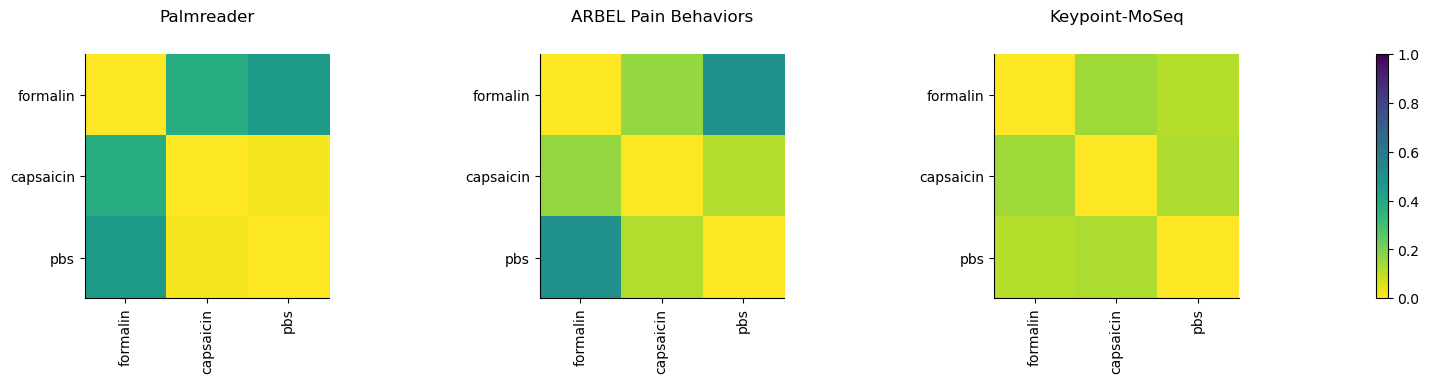

In [27]:
figure(figsize=(15,4))
gs = GridSpec(1,4, width_ratios=[10,10,10,0.3])

ax = subplot(gs[0])
cax = show_cosine(fingerprints['palmreader'])
title('Palmreader', y=1.1)
xticks(range(len(short_names)), short_names, rotation=90)
yticks(range(len(short_names)), short_names)
sns.despine()

ax = subplot(gs[1])
show_cosine(fingerprints['ARBEL'])
title('ARBEL Pain Behaviors',y=1.1)
xticks(range(len(short_names)), short_names, rotation=90)
yticks(range(len(short_names)), short_names)
sns.despine()

ax = subplot(gs[2])
show_cosine(fingerprints['kpms'])
title('Keypoint-MoSeq',y=1.1)
xticks(range(len(short_names)), short_names, rotation=90)
yticks(range(len(short_names)), short_names)
sns.despine()

ax = subplot(gs[3])
colorbar(cax, cax=ax);

plt.tight_layout()
plt.savefig(os.path.join(fig_path, f'3_item_confusion_{now}.png'))

## LDA Visualization of Mice Across Treatments

In [20]:
lda = LinearDiscriminantAnalysis(n_components=2).fit(fingerprints['kpms'], fingerprint_labels['deg'])
p = lda.transform(fingerprints['kpms'])

In [21]:
drug_class = fingerprint_labels['drug_class']
unique_class = [b for a,b in zip([""]+drug_class,drug_class) if b!=a]
drug = fingerprint_labels['drug']
unique_drug = [b for a,b in zip([""]+drug,drug) if b!=a]

KeyError: 'drug_class'

In [ ]:
color_map = dict(zip(unique_class, sns.color_palette(palette='Paired', n_colors=len(unique_class))))
class_per_drug = []

colors_ = []
for drug_ in unique_drug:
    class_ = np.array(drug_class)[np.array(drug)==drug_][0]
    colors_.append(color_map[class_])

In [ ]:
for i, treatment in enumerate(unique_drug):
    idx = fingerprint_labels['y_drug'] == i
    plot(p[idx, 0], p[idx, 1], 'o', alpha=0.1, color=colors_[i])
    x, y = np.mean(p[idx], axis=0)
    plot(x, y, 'o',
         markersize=15, color=colors_[i], label=short_name_map[treatment])
    text(x + 0.3, y, short_name_map[treatment], fontsize=10, verticalalignment='center', )
    
sns.despine()
ylim(-5, 5)
xlim(-5, 9)
xlabel('LDA 1')
ylabel('LDA 2');